In [1]:
import ROOT
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import glob
%jsroot
from tqdm import tqdm
from array import array
import itertools
from collections import defaultdict
from collections import Counter
import pandas as pd
import random
import pickle

import scipy.stats as stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.spatial import KDTree

import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import DynamicEdgeConv, TransformerConv, Set2Set, GlobalAttention
from torch.nn import Sequential, Linear, ReLU
from torch_cluster import radius_graph
from torch_geometric.nn import knn_graph
import torch.nn.functional as F
from math import acos, degrees

from torch import nn
from torch_geometric.nn import (
    DynamicEdgeConv,
    GATConv,
    global_mean_pool,
    knn_graph
)
from torch_geometric.utils import to_dense_batch
import matplotlib.patches as mpatches
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from torch_geometric.nn import JumpingKnowledge
import warnings

Welcome to JupyROOT 6.30/04


In [2]:
layout_file = ROOT.TFile("/mnt/e/testML/pie/run00000-00.root")
geohelper = layout_file.Get("PIMCGeoHelper")
layout = geohelper.GetLayout("CALORIMETER", "TP2")

In [3]:
pdg_to_idx = {pdg: i for i, pdg in enumerate([211,-13,-11,11,98105])}
# Bitmask constants (1 bit per particle type)
PION      = 0b00001  # 1
MUON      = 0b00010  # 2
POSITRON  = 0b00100  # 4
ELECTRON  = 0b01000  # 8
OTHER     = 0b10000  # 16

def pdg_to_mask(pdg_id):
    if pdg_id == 211: return PION
    elif pdg_id == -13: return MUON
    elif pdg_id == -11:       return POSITRON
    elif pdg_id == 11:        return ELECTRON
    else:                     return OTHER

MASK_TO_PDG = {
    0b00001: 211,    # pion
    0b00010: -13,     # muon
    0b00100: -11,    # positron
    0b01000: 11,     # electron
    0b10000: 98105    # other
    }

def decode_mask(mask):
    """
    Given a bitmask, return a list of PDG IDs it represents.
    """
    return [pdg for bit, pdg in MASK_TO_PDG.items() if mask & bit]

In [4]:
def smear(energy,energy_resolution):
    stdv = energy * energy_resolution
    smeared_energy = energy + np.random.normal(0,stdv)
    return smeared_energy

In [5]:
MERGE_WINDOW = 2
GROUP_WINDOW = 1
def group_hits_in_time(allHits, time_window_ns=GROUP_WINDOW):
    """
    Groups hits into clusters where each hit is within `time_window_ns`
    of the first hit in the group.

    Parameters:
        allHits: dict mapping pixelID -> list of np.array hits
                 where each hit is [x/y, z, stripType, energy, time, pdg, eventNum]
        time_window_ns: max allowed time separation within a group

    Returns:
        List of groups, where each group is a list of np.ndarray hits (no pixelID)
    """
    # Flatten all hits into a list of hit_array
    hit_list = []
    for hits in allHits.values():
        hit_list.extend(hits)

    # Sort hits by time (index 4)
    hit_list.sort(key=lambda hit: hit[4])

    #print(len(allHits), len(hit_list), "hits in total")

    groups = []
    current_group = []
    group_time = None

    for hit in hit_list:
        time = hit[4]
        if not current_group:
            current_group.append(hit)
            group_time = time
        elif abs(time - group_time) <= time_window_ns:
            current_group.append(hit)
            group_time = time
        else:
            total_energy = sum(h[3] for h in current_group)
            group_with_energy = [np.append(h, total_energy/1) for h in current_group]
            random.shuffle(group_with_energy)
            groups.append(np.array(group_with_energy))
            #random.shuffle(current_group)
            #groups.append(np.array(current_group))
            current_group = [hit]
            group_time = time

    if current_group:
        total_energy = sum(h[3] for h in current_group)
        group_with_energy = [np.append(h, total_energy/1) for h in current_group]
        random.shuffle(group_with_energy)
        groups.append(np.array(group_with_energy))
        #random.shuffle(current_group)
        #groups.append(np.array(current_group))
    #print([print(group) for group in groups])

    return groups

In [6]:
def groupID(groupList):
    """
    This function takes in a list of groups of hits, and returns the unique PDG IDs
    associated with each group, based on bitmask encoding. A PDG ID is kept only if it
    appears in at least two hits in the group; if none do, all are kept.
    """
    unique_pdg_per_group = []

    for group in groupList:
        all_decoded_pdgs = []
        for hit in group:
            mask = int(hit[5])
            all_decoded_pdgs.extend(decode_mask(mask))

        pdg_counts = Counter(all_decoded_pdgs)
        unique_pdgs = [pdg for pdg, count in pdg_counts.items() if count >= 2]

        if not unique_pdgs:
            unique_pdgs = list(pdg_counts.keys())

        unique_pdg_per_group.append(unique_pdgs)

    return unique_pdg_per_group

In [7]:
def groupMerger(groupList, prob=0.1):
    if len(groupList) != 3:
        return groupList

    if random.random() < prob:
        start_idx = random.choice([0, 1])
        idx1, idx2 = start_idx, start_idx + 1

        group1 = groupList[idx1]
        group2 = groupList[idx2]

        merged_dict = {}

        # Collect all hits from both groups
        for hit in np.concatenate((group1, group2)):
            # Define unique position key
            key = (hit[0], hit[1], int(hit[2]))  # (coord, z, stripType)

            if key not in merged_dict:
                merged_dict[key] = hit.copy()
            else:
                existing_hit = merged_dict[key]
                existing_hit[3] += hit[3]  # merge energy
                existing_hit[4] = min(existing_hit[4], hit[4])  # keep earliest time
                existing_hit[5] = int(existing_hit[5]) | int(hit[5])  # merge pdg bitmasks

        # Final merged array
        merged = np.array(list(merged_dict.values()))
        np.random.shuffle(merged)

        # Replace original groups
        for idx in sorted([idx1, idx2], reverse=True):
            groupList.pop(idx)
        groupList.insert(idx1, merged)

    return groupList

In [8]:
kPidif  = 0x0000000010
def process_time_groups(sample_chains, max_events=10000, geohelper=geohelper, enhanceMerge=False, pionstop=True, positronAngle=True):
    """
    Processes sample chains to extract time-grouped hits and their labels per event.

    Parameters:
        sample_chains (dict): Mapping of run -> TChain or iterable of entries.
        geohelper: Geometry helper with GetX/Y/Z and GetPsi methods.
        smear (func): Smearing function that takes (energy, resolution).
        group_hits_in_time (func): Function to time-group hits.
        groupID (func): Function to generate group labels from time groups.
        max_events_per_chain (int): Max number of events to process per run.

    Returns:
        eventTimeGroups (dict): Mapping event index -> grouped hit arrays.
        timeGroupLabels (dict): Mapping event index -> group label list.
    """
    MERGE_WINDOW = 2
    eventTimeGroups = np.empty(max_events, dtype=object)
    timeGroupLabels = np.empty(max_events, dtype=object)
    if pionstop:
        pionStops = np.empty(max_events, dtype=object)
    if positronAngle:
        positronAngles = np.empty(max_events, dtype=object)

    eventNumber = 0

    events_per_chain = max_events // len(sample_chains)

    for run, chain in tqdm(sample_chains.items()):
        events_taken = 0

        triggered = 0
        
        for entry in chain:

            if events_taken >= events_per_chain or eventNumber >= max_events:
                break

            eventType = int(entry.info.GetType())
            if eventType & kPidif:
                # Skip events that are of type kPidif
                continue
                
            allHits = {}

            triggered = 0
            for upstream in entry.upstream:
                if upstream.GetUpstreamID() == 99999:
                    energyDTAR = upstream.GetTotalEnergyDeposit()
                    if energyDTAR > 1:
                        triggered = 1
                    
            if not triggered:
                eventTimeGroups[eventNumber] = []
                timeGroupLabels[eventNumber] = []
                if pionstop:
                    pionStops[eventNumber] = []
                if positronAngle:
                    positronAngles[eventNumber] = []
                continue

            pion_in_atar = 0
            pion_stop_position = (-100, -100, -100)
            pion_time = 0

            thetaInit, phiInit = -1000, -1000
            positron_in_atar = 0

            evil_event= 0

            merged_pdgs_counter = {}
            merged_pixels = []

            for decay in entry.decay:
                nD = decay.GetNDaughters()
                if run == 'michel':
                    if nD != 3:
                        breaker = 1
                        continue
                    if (nD == 3):
                        #decayTime = decay.GetTime()
                        #truthMom = mom.R()
                        #truthEnergy = np.sqrt((ELECTRON_MASS ** 2) + truthMom**2) + ELECTRON_MASS
                        mom = decay.GetDaughterMomAt(2)
                        #pdg = decay.GetDaughterPDGIDAt(2)
                        thetaInit = mom.Theta()
                        phiInit = mom.Phi()
                        continue
                elif run == 'pie':
                    if nD != 2:
                        breaker = 1
                        continue
                    if (nD == 2):
                        #decayTime = decay.GetTime()
                        #truthMom = mom.R()
                        #truthEnergy = np.sqrt((ELECTRON_MASS ** 2) + truthMom**2) + ELECTRON_MASS
                        mom = decay.GetDaughterMomAt(1)
                        #pdg = decay.GetDaughterPDGIDAt(1)
                        thetaInit = mom.Theta()
                        phiInit = mom.Phi()
                        continue
            
            for atarHit in entry.atar:
                pdg = atarHit.GetPDGID()
                if pdg not in [211, -11, -13, 11]:
                    continue
            
                if pdg not in [211,-11,-13,11]:
                    print('evil')
                    evil_event = 1

                pdg_binary = pdg_to_mask(pdg)

                hitTime = atarHit.GetTime() + np.random.normal(0, 0.2)
                pixelID = atarHit.GetPixelID()
                edep = atarHit.GetEdep()
                energySmeared = smear(edep, 0.15)
                stripType = abs(abs(geohelper.GetPsi(pixelID)) - 0.0) > 0.01

                coord = geohelper.GetY(pixelID) if stripType else geohelper.GetX(pixelID)
                z = geohelper.GetZ(pixelID)
                hit = np.array([coord, z, stripType, energySmeared, hitTime, pdg_binary, eventNumber])

                if pdg == 211:
                    pion_in_atar = 1
                    if pionstop:
                        if atarHit.GetTime() > pion_time:
                            pion_time = atarHit.GetTime()
                            pion_stop_position = ((atarHit.GetX0()+atarHit.GetX1())/2, (atarHit.GetY0()+atarHit.GetY1())/2, (atarHit.GetZ0()+atarHit.GetZ1())/2)

                if pdg == -11:
                    positron_in_atar = 1


                if pixelID in allHits:
                    merged = False
                    for existing_hit in allHits[pixelID]:
                        if abs(existing_hit[4] - hitTime) < MERGE_WINDOW:
                            existing_hit[3] += energySmeared
                            existing_hit[5] = int(existing_hit[5]) | int(pdg_binary)
                            if pixelID not in merged_pixels:
                                merged_pixels.append(pixelID)
                            merged = True
                            break
                    if not merged:
                        allHits[pixelID].append(hit)
                else:
                    allHits[pixelID] = [hit]

            if len(allHits) < 10:
                evil_event = 1

            if ((not pion_in_atar) or evil_event or (not positron_in_atar)):
                eventTimeGroups[eventNumber] = []
                timeGroupLabels[eventNumber] = []
                if pionstop:
                    pionStops[eventNumber] = []
                if positronAngle:
                    positronAngles[eventNumber] = []
                continue
            
            #if len(allHits) > 200:
            #    print(len(allHits), "hits in event", eventNumber, "run", run)

            # Time-grouping
            groups = group_hits_in_time(allHits)

            #for group in groups:
            #    if len(group) > 200:
            #        print(len(group), "hits in group", eventNumber, "run", run)
                
            if enhanceMerge:
                groups = groupMerger(groups,1.0)

            groupLabels = groupID(groups)

            eventTimeGroups[eventNumber] = groups
            timeGroupLabels[eventNumber] = groupLabels
            if pionstop:
                pionStops[eventNumber] = pion_stop_position
            if positronAngle:
                positronAngles[eventNumber] = [thetaInit, phiInit]

            events_taken += 1
            eventNumber += 1

    # Find indices of empty events
    empty_indices = [i for i, groups in enumerate(eventTimeGroups) if len(groups) == 0]
    
    # Convert to NumPy arrays with object dtype to allow deletion by index
    eventTimeGroupsCleaned = np.array(eventTimeGroups, dtype=object)
    timeGroupLabelsCleaned = np.array(timeGroupLabels, dtype=object)
    pionStopsCleaned = np.array(pionStops, dtype=object) if pionstop else None
    positronAnglesCleaned = np.array(positronAngles, dtype=object) if positronAngle else None
    eventIndexCleaned = np.array(list(range(max_events)))
    
    # Remove empty events
    eventTimeGroupsCleaned = np.delete(eventTimeGroupsCleaned, empty_indices)
    timeGroupLabelsCleaned = np.delete(timeGroupLabelsCleaned, empty_indices)
    eventIndexCleaned = np.delete(eventIndexCleaned, empty_indices)
    pionStopsCleaned = np.delete(pionStopsCleaned, empty_indices) if pionstop else None
    positronAnglesCleaned = np.delete(positronAnglesCleaned, empty_indices) if positronAngle else None

    flat_arr = []
    group_index_dict = {}
    
    for event_idx, event in enumerate(timeGroupLabelsCleaned):
        for group_idx, group in enumerate(event):
            flat_arr.append(group)
            flat_index = len(flat_arr) - 1
            group_index_dict[flat_index] = (event_idx, group_idx)

    if pionstop and not positronAngle:
        return eventTimeGroupsCleaned, timeGroupLabelsCleaned, eventIndexCleaned, group_index_dict, pionStopsCleaned
    elif positronAngle:
        return eventTimeGroupsCleaned, timeGroupLabelsCleaned, eventIndexCleaned, group_index_dict, pionStopsCleaned, positronAnglesCleaned
    else:
        return eventTimeGroupsCleaned, timeGroupLabelsCleaned, eventIndexCleaned, group_index_dict

In [9]:
class PositronAngleDataset(Dataset):
    def __init__(self, event_positron_group,  positron_angle, pion_stops):
        self.groups = [group[-1] for group in event_positron_group] # Only works when you know that the positron is in the last time group
        self.pion_stops = pion_stops
        self.positron_angle = positron_angle

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        group = np.array(self.groups[idx])
        coords = group[:, 0]
        zs = group[:, 1]
        strip_types = group[:, 2].astype(int)
        energy = group[:, 3]
        times = group[:, 4]
        pdgs = group[:, 5].astype(int)
        event_number = group[:, 6]
        group_energy = group[:, 7]

        # Feature construction
        view0 = (strip_types == 0).astype(float)
        view1 = (strip_types == 1).astype(float)

        x = torch.tensor(np.stack([coords, zs, energy, view0, view1, group_energy], axis=1), dtype=torch.float)

        angles = self.positron_angle[idx]
        vec3d = torch.tensor([np.sin(angles[0]) * np.cos(angles[1]),
                              np.sin(angles[0]) * np.sin(angles[1]),
                              np.cos(angles[0])], dtype=torch.float)

        event_id = torch.tensor(event_number, dtype=torch.int)
        pion_stop = torch.tensor(self.pion_stops[idx], dtype=torch.float)
        if pion_stop.dim() == 1:
            pion_stop = pion_stop.unsqueeze(0)

        return Data(x=x, y=vec3d, event_id=event_id, pion_stop=pion_stop)

In [29]:
class FullTransformerBlock(nn.Module):
    def __init__(self, hidden_channels, heads, dropout):
        super().__init__()
        self.attn = TransformerConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels // heads,
            heads=heads,
            dropout=dropout,
            concat=True,
            beta=True,
            edge_dim=4
        )
        self.norm1 = nn.LayerNorm(hidden_channels)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 4),
            nn.ReLU(),
            nn.Linear(hidden_channels * 4, hidden_channels)
        )
        self.norm2 = nn.LayerNorm(hidden_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr=None):
        y = self.attn(x, edge_index, edge_attr)
        x = self.norm1(x + self.dropout(y))
        y2 = self.ffn(x)
        x = self.norm2(x + self.dropout(y2))
        return x
    
class EPlusAnglePredictorGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=4, num_blocks=2, dropout=0.2):
        super().__init__()
        self.lin_embed = nn.Linear(in_channels, hidden_channels)

        # Stacked Transformer blocks (edge-aware)
        self.blocks = nn.ModuleList([
            FullTransformerBlock(hidden_channels, heads, dropout) for _ in range(num_blocks)
        ])

        # Jumping Knowledge across all blocks
        self.jk_layer = JumpingKnowledge(mode='cat')
        jk_output_channels = hidden_channels * num_blocks

        # Global Attention pooling
        self.pool = GlobalAttention(
            gate_nn=nn.Sequential(
                nn.Linear(jk_output_channels, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        )
        
        # replace the 3‐output head with a 3‐D direction head:
        self.output = nn.Sequential(
            nn.Linear(jk_output_channels + 3, hidden_channels * 2), # extra 3 for the pion stop position
            nn.ReLU(),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 3)  # direction vector of the positron
        )

    def forward(self, data):
        x_raw = data.x
        x, batch = self.lin_embed(x_raw), data.batch

        # Build a complete graph within each batch element
        edge_indices = []
        for event_id in torch.unique(batch):
            mask = batch == event_id
            idx = mask.nonzero(as_tuple=True)[0]
            num = idx.size(0)
            row = torch.arange(num, device=idx.device).repeat_interleave(num)
            col = torch.arange(num, device=idx.device).repeat(num)
            mask_nc = row != col
            ei = torch.stack([idx[row[mask_nc]], idx[col[mask_nc]]], dim=0)
            edge_indices.append(ei)

        edge_index = torch.cat(edge_indices, dim=1)  # shape: [2, E]

        # ---- Build edge attributes ----
        pos2d = x_raw[:, :2]                          # first 2 coords
        delta = pos2d[edge_index[1]] - pos2d[edge_index[0]]  # [E, 2]

        energy = x_raw[:, 2]
        dE = (energy[edge_index[1]] - energy[edge_index[0]]).unsqueeze(1)  # [E, 1]

        view0, view1 = x_raw[:, 3], x_raw[:, 4]
        same_view = ((view0[edge_index[1]] * view0[edge_index[0]]) +
                     (view1[edge_index[1]] * view1[edge_index[0]])).unsqueeze(1)  # [E, 1]

        edge_attr = torch.cat([delta, dE, same_view], dim=1)  # [E, 4]

        # ---- Transformer blocks with JumpingKnowledge ----
        layer_outputs = []
        for block in self.blocks:
            x = block(x, edge_index, edge_attr)  # use edge_attr here
            layer_outputs.append(x)

        xjk = self.jk_layer(layer_outputs)       # [N, hidden_channels * num_blocks]

        # ---- Pool to group-level ----
        x_group = self.pool(xjk, batch)          # [B, hidden_channels * num_blocks]

        # Append pion_stop to pooled group features
        pion_stop = data.pion_stop  # shape: [batch_size, 3]
        pion_dir = F.normalize(data.pion_stop, p=2, dim=1)
        x_combined = torch.cat([x_group, pion_dir], dim=1)  # [batch_size, hidden_channels + 3]

        # raw 3‐vector
        v = self.output(x_combined)
        # normalize to unit length
        v = F.normalize(v, p=2, dim=1)
        return v 

In [11]:
def compute_direction_loss_and_error(output, target):
    """
    output: (B,3) predicted unit vectors
    target: (B,3) true   unit vectors
    returns: (loss, mean_angle_error_deg)
    """
    # Cosine‐similarity loss: L = 1 - <v_pred, v_true>
    # Ensure output and target are normalized
    cos_sim = F.cosine_similarity(output, target, dim=1)  # (B,)
    loss = (1 - cos_sim).mean()

    # Angular error per sample (in degrees):
    # Clamp to [-1,1] to avoid NaNs from float error
    cos_sim_clamped = cos_sim.clamp(-1.0 + 1e-6, 1.0 - 1e-6)
    angles_rad = torch.acos(cos_sim_clamped)             # (B,) in radians
    angles_deg = angles_rad * (180.0 / torch.pi)
    mean_angle_error = angles_deg.mean()

    #print("Cosine sim min/max:", cos_sim.min().item(), cos_sim.max().item())
    #print("Norms:", output.norm(dim=1).mean().item(), target.norm(dim=1).mean().item())
    #print()

    return loss, mean_angle_error.item()

In [12]:
def train_angle_model(model, loader, optimizer, scheduler=None, num_epochs=10):
    """
    Training loop for EPlusAnglePredictorGNN.
    Reports cosine-loss and mean angular error (deg) each epoch.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    history = []
    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        total_ang_err = 0.0
        counter = 0

        for data in loader:

            #if counter % 1000 == 0:
            #    print(f"[Batch {counter}] Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB | Reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
            data = data.to(device)
            optimizer.zero_grad()

            pred_dir = model(data)       # (batch_size, 3), already normalized
            true_dir = data.y.float().view(-1, 3) # (batch_size, 3)

            loss, ang_err = compute_direction_loss_and_error(pred_dir, true_dir)
            #print(loss.item(), ang_err)
            loss.backward()
            optimizer.step()
            counter += 1

            total_loss    += loss.item() * data.y.size(0)/3
            total_ang_err += ang_err      * data.y.size(0)/3

            # Clean memory
            del data, pred_dir, true_dir, loss, ang_err
            torch.cuda.empty_cache()

        n = len(loader.dataset)
        avg_loss    = total_loss / n
        avg_ang_err = total_ang_err / n

        print(f"Epoch {epoch:02d}: Cosine-Loss = {avg_loss:.4f}, Mean Angle Error = {avg_ang_err:.2f}°")
        history.append({
            "epoch": epoch,
            "cosine_loss": avg_loss,
            "mean_angle_error_deg": avg_ang_err
        })

        if scheduler is not None:
            scheduler.step(avg_loss)

    return history

In [13]:
def evaluate_angle_model_mc_dropout(
    model, dataset,
    batch_size=1, num_samples=10,
    failure_threshold_deg=30.0,  # degrees
    plot=True
):
    """
    Evaluates a unit‐vector regression model using MC Dropout.
    Returns:
        mean_error_deg (float): mean angular error in degrees
        failures (list of (index, true_vec, mean_pred_vec, angle_deg))
        all_angles_deg (list of float)
        all_mean_preds (np.ndarray [N,3])
        all_targets     (np.ndarray [N,3])
    """
    model.train()  # keep dropout active
    device = next(model.parameters()).device
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    total_angle = 0.0
    total_samples = 0
    all_mean_preds = []
    all_targets    = []
    all_angles_deg = []
    failures = []

    with torch.no_grad():
        for i, data in enumerate(loader):
            data = data.to(device)
            target = data.y.float()       # [B,3], assumed unit‐norm

            # S samples each of shape [B,3]
            preds = torch.stack([model(data) for _ in range(num_samples)], dim=0)
            mean_pred = preds.mean(dim=0)            # [B,3]
            mean_pred = F.normalize(mean_pred, dim=1)  # renormalize

            # cosine similarities and angular errors
            cos_sim = F.cosine_similarity(mean_pred, target, dim=1).clamp(-1,1)
            angles_rad = torch.acos(cos_sim)          # [B]
            angles_deg = angles_rad * (180.0 / torch.pi)

            all_mean_preds.append(mean_pred.cpu())
            all_targets.append(target.cpu())
            all_angles_deg.extend(angles_deg.cpu().tolist())

            total_angle   += angles_deg.sum().item()
            total_samples += angles_deg.size(0)

            # record failures
            for j, angle in enumerate(angles_deg):
                ang = angle.item()
                if ang > failure_threshold_deg:
                    true_vec = target[j].cpu().numpy()
                    pred_vec = mean_pred[j].cpu().numpy()
                    failures.append((i * batch_size + j, true_vec, pred_vec, ang))
            
            del data, target, preds, mean_pred, cos_sim, angles_rad, angles_deg
            torch.cuda.empty_cache()

    # aggregate
    all_mean_preds = torch.cat(all_mean_preds, dim=0).numpy()  # [N,3]
    all_targets    = torch.cat(all_targets,    dim=0).numpy()  # [N,3]
    mean_error_deg = total_angle / total_samples if total_samples else 0.0

    print(f"MC Dropout Mean Angular Error: {mean_error_deg:.2f}° over {total_samples} samples")
    print(f"Failures (> {failure_threshold_deg:.1f}°): {len(failures)}")

    if plot:
        plt.figure(figsize=(8,5))
        plt.hist(all_angles_deg, bins=40, alpha=0.8)
        plt.xlabel("Angular Error (degrees)")
        plt.ylabel("Count")
        plt.title("Histogram of Angular Errors under MC Dropout")
        #plt.yscale('log')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    return mean_error_deg, failures, all_angles_deg, all_mean_preds, all_targets

In [14]:
main_file_list = ['michel']
main_chains = {s : ROOT.TChain("sim") for s in main_file_list}
for name,c in main_chains.items():
    print(name)
    #[c.Add(filepath) for filepath in glob.glob("/mnt/e/testML/{}/*.root".format(name))]
    [c.Add(filepath) for filepath in glob.glob("/mnt/e/testML/testData/{}/*.root".format(name))]

pie_file_list = ['pie']
pie_chains = {s : ROOT.TChain("sim") for s in pie_file_list}
for name,c in pie_chains.items():
    print(name)
    #[c.Add(filepath) for filepath in glob.glob("/mnt/e/testML/{}/*.root".format(name))]
    [c.Add(filepath) for filepath in glob.glob("/mnt/e/testML/testData/{}/*.root".format(name))]

michel
pie


In [15]:
mainTimeGroups, mainTimeGroupLabels, mainEventIndex, main_group_index_dict, pStops, posAngles = process_time_groups(main_chains, max_events=100000, geohelper=geohelper)

100%|██████████| 1/1 [09:23<00:00, 563.51s/it]


In [16]:
pieTimeGroups, pieTimeGroupLabels, pieEventIndex, pie_group_index_dict, piepStops, pieposAngles = process_time_groups(pie_chains, max_events=90000, geohelper=geohelper)

100%|██████████| 1/1 [08:34<00:00, 514.13s/it]


In [17]:
pie_dataset = PositronAngleDataset(pieTimeGroups, pieposAngles, piepStops)
pie_loader = DataLoader(pie_dataset, batch_size=64, shuffle=True)

In [45]:
main_dataset = PositronAngleDataset(mainTimeGroups[:100000], posAngles[:100000], pStops[:100000])
main_loader = DataLoader(main_dataset, batch_size=64, shuffle=True)

In [30]:
main_model = EPlusAnglePredictorGNN(in_channels=6, hidden_channels=128, num_blocks=2, dropout=0.05)

In [33]:
main_optimizer = torch.optim.Adam(main_model.parameters(), lr=0.0001,  weight_decay=1e-5)
scheduler = ReduceLROnPlateau(main_optimizer, 'min', factor=0.3, patience=3)

In [82]:
main_model = main_model.to("cuda")
main_history = train_angle_model(main_model, pie_loader, main_optimizer, scheduler, num_epochs=100)

KeyboardInterrupt: 

MC Dropout Mean Angular Error: 5.93° over 100000 samples
Failures (> 40.0°): 682


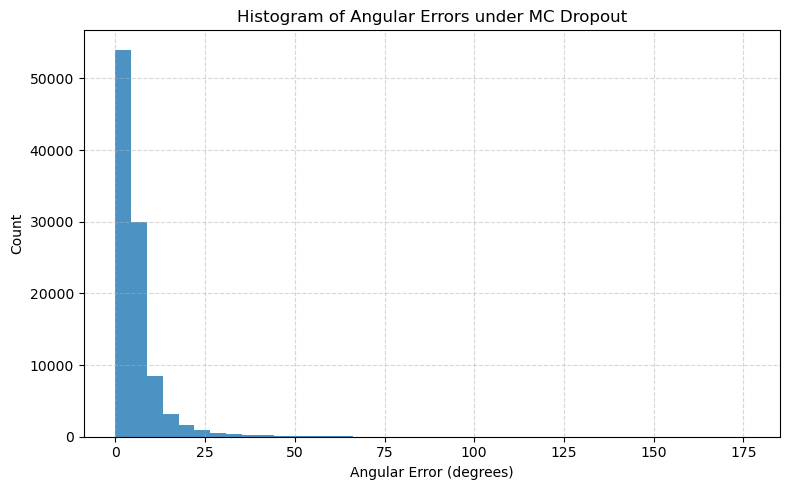

In [46]:
mean_error_deg, failures, all_angles_deg, all_mean_preds, all_targets = evaluate_angle_model_mc_dropout(
    model=main_model, dataset=main_dataset,num_samples=4, failure_threshold_deg=40.0)

MC Dropout Mean Angular Error: 6.88° over 90000 samples
Failures (> 40.0°): 2993


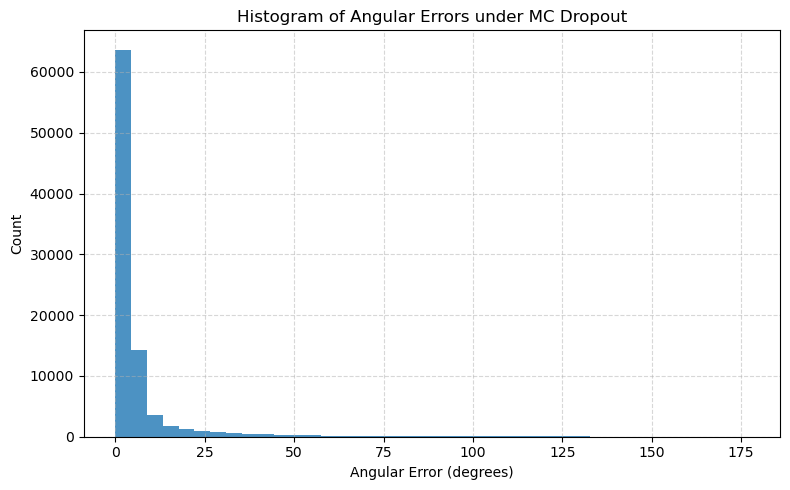

In [47]:
mean_error_deg_pie, failures_pie, all_angles_deg_pie, all_mean_preds_pie, all_targets_pie = evaluate_angle_model_mc_dropout(
    model=main_model, dataset=pie_dataset,num_samples=4, failure_threshold_deg=40.0)

In [48]:
def compute_theta_differences_from_angles(posAngles, all_mean_preds):

    delta_theta = []

    for truth, pred in zip(posAngles, all_mean_preds):
        theta = truth[0]
        pred_norm = np.linalg.norm(pred)
        theta_pred = np.arccos(pred[2] / pred_norm)
        delta_theta.append(np.degrees(theta - theta_pred))

    return np.array(delta_theta)

In [49]:
diffTheta = compute_theta_differences_from_angles(posAngles, all_mean_preds)
diffThetaCleaned = np.array([val for val in diffTheta if abs(val) <= 180])

failsTheta = np.where(np.abs(diffTheta) > 20)[0]

In [ ]:
#merged_pie = [0 if 5 in pieTimeGroups[i][-1][:, 5].astype(int) else 1 for i in range(len(pieTimeGroups))]
#merged_mask = [bool(x) for x in merged_pie]

mask = []
for group in pieTimeGroups:
    try:
        mask.append(5 not in group[-1][:, 5].astype(int))
    except:
        mask.append(False)

In [ ]:
diffThetapie = compute_theta_differences_from_angles(pieposAngles, all_mean_preds_pie)
diffThetaCleanedpie = np.array([val for val in diffThetapie[mask] if abs(val) <= 180])
cleaned_mask_pie = np.array([val for val in diffThetapie[mask] if abs(val) <= 180])
failsThetapie = np.where(np.abs(diffThetapie) > 50)[0]

In [129]:
binned_errors_michel = ROOT.TH2F("binned_errors_michel", "", 35, 0, 180, 200, -50, 50)
binned_errors_pie = ROOT.TH2F("binned_errors_pie", "", 35, 0, 180, 200, -50, 50)

Warning in <TFile::Append>: Replacing existing TH1: binned_errors_michel (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: binned_errors_pie (Potential memory leak).


In [130]:
for truth, error in zip(posAngles, diffTheta):
    if abs(error) > 180:
        continue
    true_theta = np.degrees(truth[0])
    binned_errors_michel.Fill(true_theta,error)

for truth, error in zip(pieposAngles[mask], diffThetapie[mask]):
    if abs(error) > 180:
        continue
    true_theta = np.degrees(truth[0])
    binned_errors_pie.Fill(true_theta,error)

In [131]:
c = ROOT.TCanvas()
binned_errors_pie.Draw('col')
c.Draw()

In [132]:
std_dev_list_michel = []
std_dev_list_pie = []
    
n_bins_x = 35

for i_x in range(1, n_bins_x + 1):
    y_projection = binned_errors_michel.ProjectionY(f"y_proj_x{i_x}", i_x, i_x)
    std_dev_list_michel.append(y_projection.GetStdDev())

for i_x in range(1, n_bins_x + 1):
    y_projection = binned_errors_pie.ProjectionY(f"y_proj_x{i_x}", i_x, i_x)
    std_dev_list_pie.append(y_projection.GetStdDev())

In [5]:
performance_michel = [3.6197061190030717, 3.5609477274175365, 3.671115454140868, 3.821101738379328, 4.1056971338671735, 3.9114220350657702, 4.39923851859788, 4.758107069853539, 4.505217479770635, 4.914925487025685, 5.1084935320001525, 5.081863658711598, 4.932874479190457, 5.194682376672866, 5.180144069750324, 5.354789342545291, 5.291348313549401, 5.582039863752914, 5.622682673434196, 5.026475749106207, 4.933330247345334, 5.165294812470456, 4.877268755638682, 4.764941545883772, 4.286064819275393, 4.54539573994397, 4.063380087365409, 3.981709639262571, 3.898571754581424, 3.626278455479538, 3.983511800514511, 3.5935942875007343, 3.892476650481463, 3.199520545415628, 3.6194430757824767]
performance_pie = [3.2211938427805085, 2.3967142632708907, 2.6497250068710323, 2.9383437748057406, 2.3384862049790063, 3.1192201229290637, 3.5483028013739824, 2.9302855236141365, 2.926730697370064, 3.0550039175943238, 3.557022483152541, 3.3144405913623545, 3.3115357020343272, 3.292324394612658, 3.0247931515384114, 3.2408273216678767, 3.345630974855783, 3.689992981451666, 3.37913690615552, 3.460002962184525, 2.9411946869868566, 2.7538657630377235, 3.1272388557150554, 3.094328282385115, 2.8068384088933236, 3.2038744894852975, 2.8569621478244454, 3.4388267252253972, 3.1917839433788338, 2.6491749077837747, 2.450148459085779, 2.4733751444687577, 3.1900615312721583, 3.431834669193127, 3.543186393075388]

In [27]:
print(len(performance_michel))

35


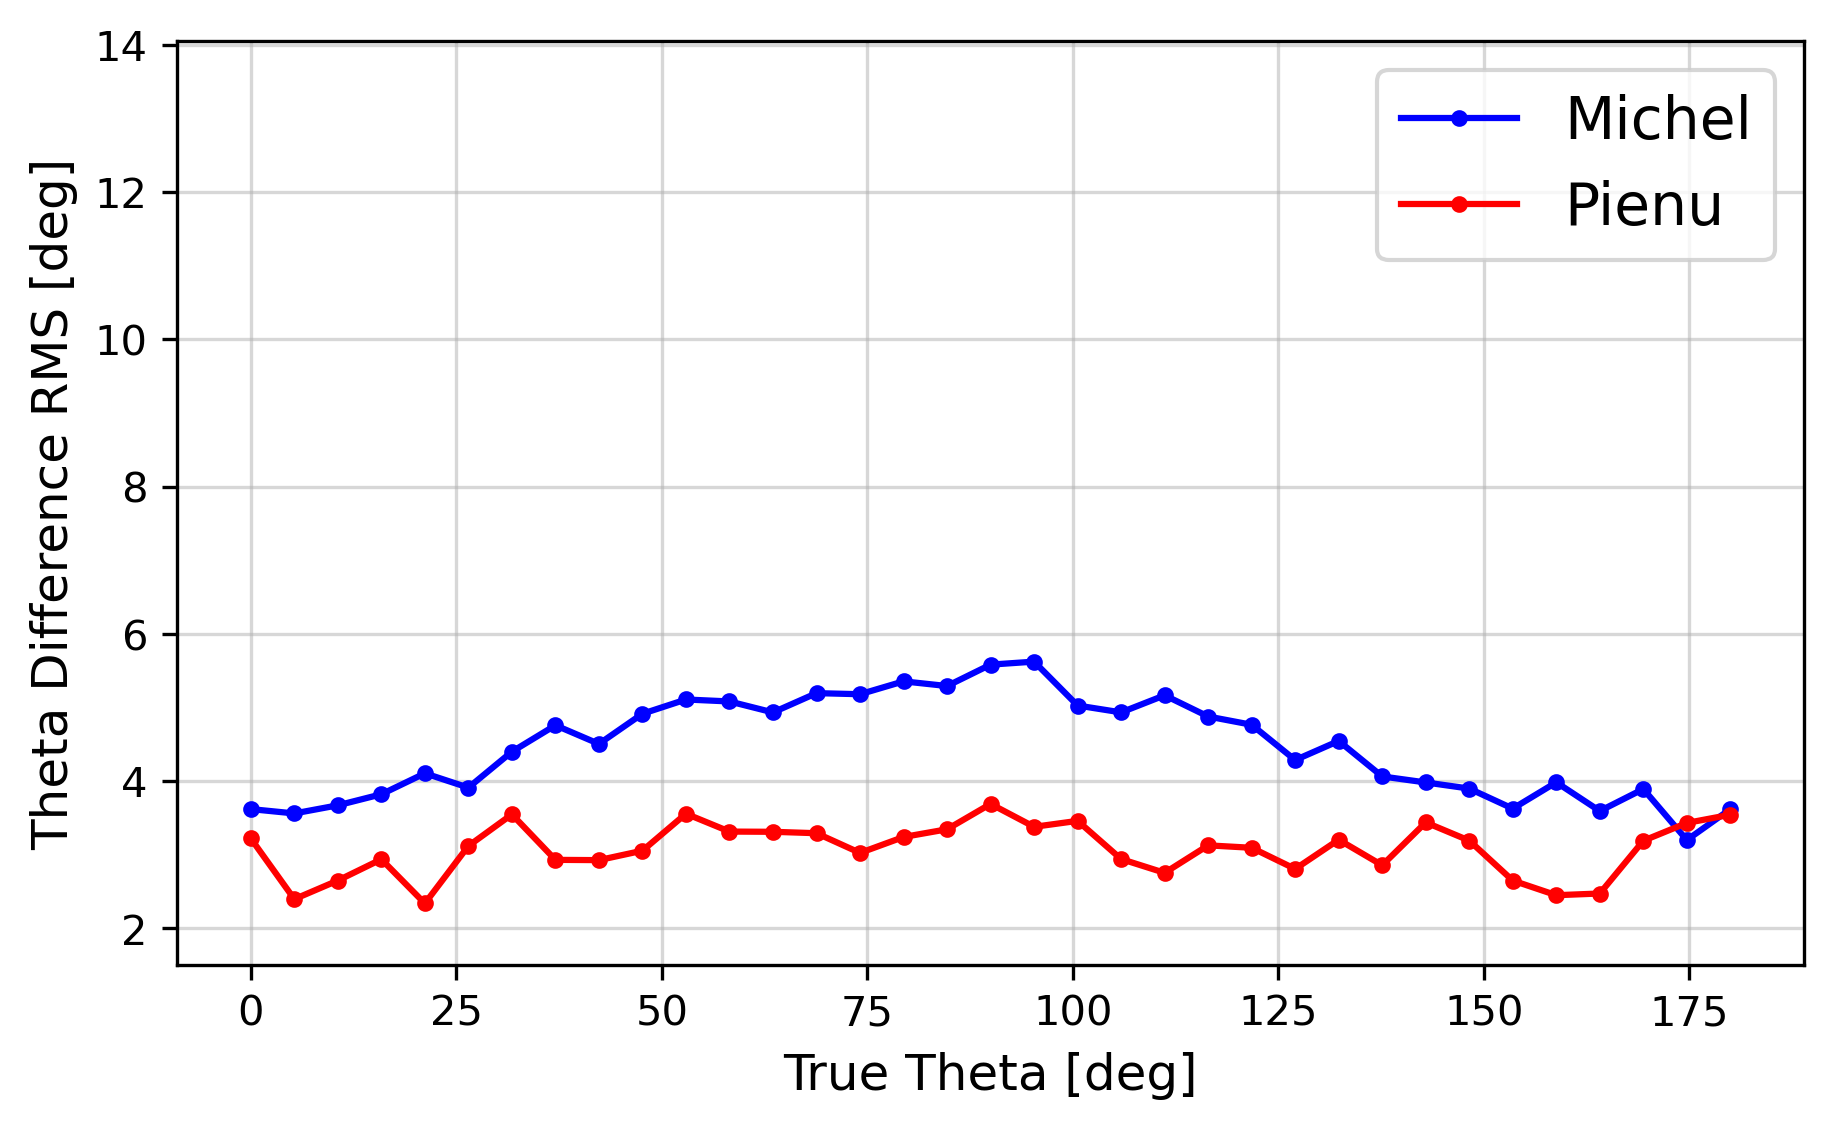

In [ ]:
plt.figure(figsize=(7, 4), dpi=300)
plt.plot(np.linspace(0,180,35),performance_michel, marker='o',markersize=3, color='b', label='Michel')
plt.plot(np.linspace(0,180,35),performance_pie, marker='o',markersize=3, color='r', label='Pienu')
#plt.gca().set_aspect(9.5)
plt.xlabel("True Theta [deg]", fontsize=12)
plt.ylabel("Theta Difference RMS [deg]", fontsize=12)
plt.ylim(1.5,14.05)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.5)
#plt.savefig(f'/mnt/c/Users/obbee/OneDrive/Pictures/plots/theta_positronAI.png', dpi=300)

In [143]:
print(std_dev_list_michel)
print(std_dev_list_pie)

[3.6197061190030717, 3.5609477274175365, 3.671115454140868, 3.821101738379328, 4.1056971338671735, 3.9114220350657702, 4.39923851859788, 4.758107069853539, 4.505217479770635, 4.914925487025685, 5.1084935320001525, 5.081863658711598, 4.932874479190457, 5.194682376672866, 5.180144069750324, 5.354789342545291, 5.291348313549401, 5.582039863752914, 5.622682673434196, 5.026475749106207, 4.933330247345334, 5.165294812470456, 4.877268755638682, 4.764941545883772, 4.286064819275393, 4.54539573994397, 4.063380087365409, 3.981709639262571, 3.898571754581424, 3.626278455479538, 3.983511800514511, 3.5935942875007343, 3.892476650481463, 3.199520545415628, 3.6194430757824767]
[3.2211938427805085, 2.3967142632708907, 2.6497250068710323, 2.9383437748057406, 2.3384862049790063, 3.1192201229290637, 3.5483028013739824, 2.9302855236141365, 2.926730697370064, 3.0550039175943238, 3.557022483152541, 3.3144405913623545, 3.3115357020343272, 3.292324394612658, 3.0247931515384114, 3.2408273216678767, 3.345630974

5.2033047113090305
0.13653406167692778
-159.88522466221255


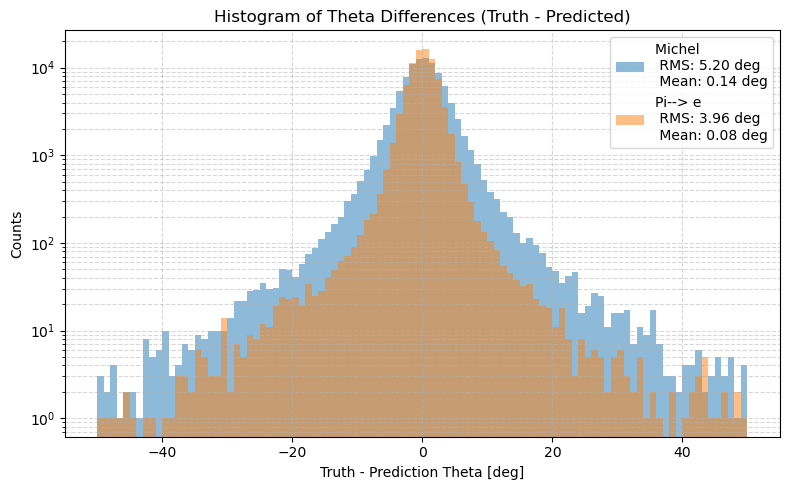

In [108]:
print(np.std(diffThetaCleaned))
print(np.mean(diffThetaCleaned))
print(min(diffThetaCleaned))

plt.figure(figsize=(8,5))
plt.hist(diffThetaCleaned, bins=100, range=(-50, 50), alpha=0.5, label='Michel \n RMS: {:.2f} deg \n Mean: {:.2f} deg'.format(np.std(diffThetaCleaned), np.mean(diffThetaCleaned)))
plt.hist(diffThetaCleanedpie, bins=100, range=(-50, 50), alpha=0.5, label='Pi--> e \n RMS: {:.2f} deg \n Mean: {:.2f} deg'.format(np.std(diffThetaCleanedpie), np.mean(diffThetaCleanedpie)))
plt.xlabel("Truth - Prediction Theta [deg]")
plt.ylabel("Counts")
plt.title("Histogram of Theta Differences (Truth - Predicted)")
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

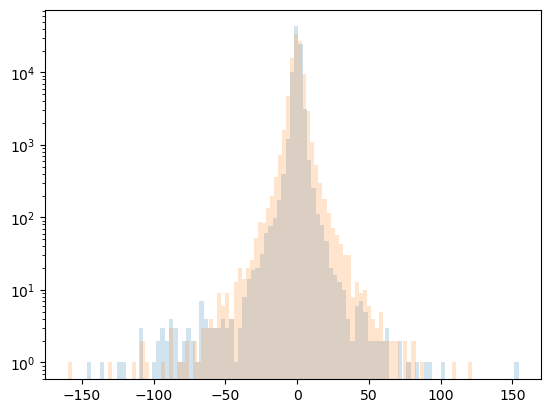

In [135]:
plt.hist(diffThetaCleanedpie, bins=100, alpha=0.2)
plt.hist(diffThetaCleaned, bins=100, alpha=0.2)
plt.yscale('log')

In [59]:
print(failsThetapie)

[  457   541   733   830   925  1036  1183  1268  1337  1440  1488  1553
  1624  1631  1988  2003  2331  2377  2482  2645  2821  2863  3004  3173
  3204  3372  3481  3630  3644  3717  3828  3833  4063  4175  4284  4398
  4406  4467  4533  4626  4641  5295  5479  5501  5632  5653  5737  5745
  5787  5818  5824  6344  7048  7245  7288  7398  7676  7935  7950  8093
  8351  8383  8830  8946  9030  9126  9519  9537  9604  9637  9650  9739
  9756 10259 10438 10477 10604 10745 10968 11037 11365 11367 11412 11617
 11621 11913 11945 12012 12024 12077 12104 12139 12141 12154 12331 12471
 12547 12852 13424 13512 13824 13965 14181 14503 14563 14735 14835 14873
 15061 15070 15152 15257 15272 15406 15554 15778 15954 15960 15980 16343
 16614 16747 16816 17058 17088 17127 17216 17503 17577 17646 17673 17676
 18091 18232 18249 18311 18514 18573 18598 18700 18962 18989 19027 19036
 19037 19178 19198 19255 19336 19829 19853 20000 20032 20152 20153 20266
 20374 20401 20572 20599 20932 20939 21192 21694 21

[ 63.89160821 -38.3931594 ]
66.052795 -32.970936
2.1611909859457725 5.422220933408195


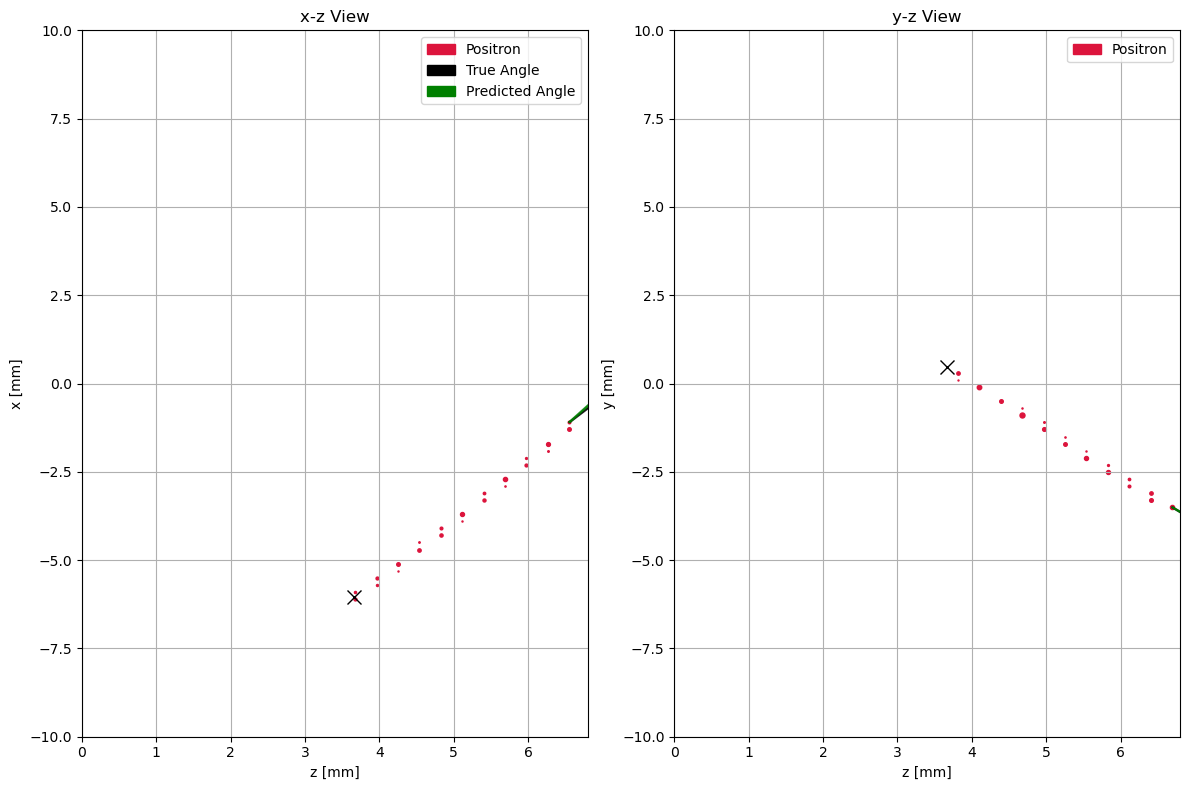

In [140]:
event_num = 125
#event_num = f_index

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
particle_colors = {
    1: ("red", "Pion"),
    2: ("blue", "Muon"),
    3: ("purple", "Muon + Pion"),
    4: ("crimson", "Positron")
}
default_color = ("gray", "Other")

group = pieTimeGroups[event_num][-1]
positions = group[:, :2]
energies = group[:, 3]
times = group[:, 4]
pdgs = group[:, 5].astype(int)
hViews = group[:, 2].astype(int)

true_pion_stop = piepStops[event_num]
true_angle = pieposAngles[event_num]
pred_angle = all_mean_preds_pie[event_num]
predTheta, predPhi = np.arccos(pred_angle[2]/np.linalg.norm(pred_angle)), np.arctan2(pred_angle[1], pred_angle[0])

print(np.degrees(true_angle))
print(np.degrees(predTheta), np.degrees(predPhi))
print(np.degrees(predTheta - true_angle[0]), np.degrees(predPhi - true_angle[1]))

theta, phi = true_angle
true_vec = np.array([
    np.sin(theta) * np.cos(phi),
    np.sin(theta) * np.sin(phi),
    np.cos(theta)
])



#first_hit = group[0]
#coord, z = first_hit[0], first_hit[1]
#view = int(first_hit[2])

arrow_scale = 1
#print(pdgs)



for i in range(2):  # i = 0 for x view, 1 for y view
    ax = axs[i]
    view_mask = (hViews == i)
    h2D = positions[view_mask]
    hEs = energies[view_mask]
    hPDGs_view = pdgs[view_mask]
    htimes = times[view_mask]

    first_hit = max(h2D[:,1])
    first_hit_pos = h2D[h2D[:,1] == first_hit][0]

    colors = [particle_colors.get(p, default_color)[0] for p in hPDGs_view]

    for j, (x_or_y, z_) in enumerate(h2D):
        ax.scatter(z_, x_or_y, c=colors[j], s=100 * hEs[j])

    # Plot pion stop
    ax.plot(true_pion_stop[2], true_pion_stop[i], 'x', color='black', markersize=10, label='True Pion Stop')

    # Plot angle vectors starting from first hit
    if i == 0:
        dy_true = true_vec[0]
        dy_pred = pred_angle[0]
    else:
        dy_true = true_vec[1]
        dy_pred = pred_angle[1]

    dz_true = true_vec[2]
    dz_pred = pred_angle[2]

    ax.arrow(first_hit_pos[1], first_hit_pos[0], dz_true * arrow_scale, dy_true * arrow_scale,
             color='black', width=0.02, head_width=0.2, label='True Angle', alpha=0.8)
    ax.arrow(first_hit_pos[1], first_hit_pos[0], dz_pred * arrow_scale, dy_pred * arrow_scale,
             color='green', width=0.02, head_width=0.2, label='Predicted Angle', alpha=0.8)

    # Legends
    unique_pdgs = np.unique(hPDGs_view)
    legend_patches = []
    seen_labels = set()
    for pdg in unique_pdgs:
        color, label = particle_colors.get(pdg, default_color)
        if label not in seen_labels:
            legend_patches.append(mpatches.Patch(color=color, label=label))
            seen_labels.add(label)

    # Add arrows to legend only once
    if i == 0:
        legend_patches.append(mpatches.Patch(color='black', label='True Angle'))
        legend_patches.append(mpatches.Patch(color='green', label='Predicted Angle'))

    ax.legend(handles=legend_patches, loc='upper right')
    ax.set_xlabel("z [mm]")
    ax.set_ylabel("x [mm]" if i == 0 else "y [mm]")
    ax.set_title(f"{'x' if i == 0 else 'y'}-z View")
    ax.grid(True)
    ax.set_xlim(0, 6.8)
    ax.set_ylim(-10, 10)

plt.tight_layout()
plt.show()


In [ ]:
torch.save(main_model.state_dict(), '/mnt/e/testML/positronAngleV2.pth')